# Analyse der Brustkrebsdaten

In [1]:
#Load Libraries
import sqlite3
import pandas as pd

# Load GitHub repo
%cd /content/
%rm -r ./DMA2022DataProjectB
!git clone https://github.com/Fuenfgeld/DMA2022DataProjectB.git
    
%cd ./DMA2022DataProjectB/

[Errno 2] No such file or directory: '/content/'
/Volumes/Macintosh HD - Data/Users/mariiarobota/My documents/Studium/Master/DAF/DMA2022DataProjectB
rm: ./DMA2022DataProjectB: No such file or directory
Cloning into 'DMA2022DataProjectB'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 69 (delta 5), reused 5 (delta 2), pack-reused 55
Receiving objects: 100% (69/69), 2.03 MiB | 17.80 MiB/s, done.
Resolving deltas: 100% (27/27), done.
/Volumes/Macintosh HD - Data/Users/mariiarobota/My documents/Studium/Master/DAF/DMA2022DataProjectB/DMA2022DataProjectB


In [2]:
# Connect to Database
conn = sqlite3.connect('breast_cancer.db')
cursor = conn.cursor()
print("Opened database successfully");

Opened database successfully


In [78]:
# Delete table if exists 
cursor.execute("DROP TABLE IF EXISTS patient")
cursor.execute("DROP TABLE IF EXISTS condition")
cursor.execute("DROP TABLE IF EXISTS medication")
cursor.execute("DROP TABLE IF EXISTS observation")
cursor.execute("DROP TABLE IF EXISTS description")

In [79]:
# Load data
patient = pd.read_csv('BreastCancerData/patients.csv', sep=",")
condition = pd.read_csv('BreastCancerData/conditions.csv', sep=",")
medication = pd.read_csv('BreastCancerData/medications.csv', sep=",")
observation = pd.read_csv('BreastCancerData/observations.csv', sep=",")

In [14]:
patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1019 entries, 0 to 1018
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   1019 non-null   object 
 1   BIRTHDATE            1019 non-null   object 
 2   DEATHDATE            19 non-null     object 
 3   SSN                  1019 non-null   object 
 4   DRIVERS              854 non-null    object 
 5   PASSPORT             803 non-null    object 
 6   PREFIX               831 non-null    object 
 7   FIRST                1019 non-null   object 
 8   LAST                 1019 non-null   object 
 9   SUFFIX               15 non-null     object 
 10  MAIDEN               280 non-null    object 
 11  MARITAL              689 non-null    object 
 12  RACE                 1019 non-null   object 
 13  ETHNICITY            1019 non-null   object 
 14  GENDER               1019 non-null   object 
 15  BIRTHPLACE           1019 non-null   o

In [15]:
patient.head()

,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,SUFFIX,...,BIRTHPLACE,ADDRESS,CITY,STATE,COUNTY,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE
0,d2061cc7-bee0-0e6c-3ac4-15c197c474e0,1956-06-22,NaN,999-51-6528,S99944910,X29408602X,Mr.,Lucio648,Simonis280,NaN,...,Worcester Massachusetts US,636 Wiegand Loaf,Cambridge,Massachusetts,Middlesex County,2140.0,42.359926,-71.113260,1475230.00,4244.64
1,073d8e80-ff90-1c8d-57e4-29bfca52c87f,1964-08-28,NaN,999-90-4728,S99976204,X17497441X,Mrs.,Buffy238,Wolf938,NaN,...,Somerville Massachusetts US,972 Satterfield Trafficway Apt 71,North Brookfield,Massachusetts,Worcester County,1535.0,42.257845,-72.026317,1489125.00,4016.36
2,e1ff7e68-4097-9faf-514d-e4cfcfdf252e,1998-08-28,NaN,999-82-3645,S99973929,X88553898X,Ms.,Debora709,Klocko335,NaN,...,Williamstown Massachusetts US,589 Koss Station,Worcester,Massachusetts,Worcester County,1545.0,42.204290,-71.818449,57142.44,2103.20
3,a0f679cc-875f-dd72-ed13-9ca863ec6cf3,2004-01-20,NaN,999-93-6431,S99923001,NaN,NaN,Walton167,Kessler503,NaN,...,New Braintree Massachusetts US,777 Gusikowski Drive,Weymouth,Massachusetts,Norfolk County,NaN,42.150270,-70.904084,408520.00,2709.00
4,e4166a9c-f7c5-bef7-ea43-b96281a2d586,2006-03-23,NaN,999-11-8697,NaN,NaN,NaN,Mariano761,Wiegand701,NaN,...,Canton Massachusetts US,156 Herman Knoll,Worcester,Massachusetts,Worcester County,1609.0,42.292082,-71.784873,320400.00,2970.68


In [17]:
condition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   START        222 non-null    object 
 1   STOP         0 non-null      float64
 2   PATIENT      222 non-null    object 
 3   ENCOUNTER    222 non-null    object 
 4   CODE         222 non-null    int64  
 5   DESCRIPTION  222 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ KB


In [11]:
condition.head()

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION
0,2018-08-31,NaN,d2061cc7-bee0-0e6c-3ac4-15c197c474e0,5075ad6e-11d5-017d-f011-253c838a1d86,53741008,Coronary Heart Disease
1,1984-11-07,NaN,b4001499-a15a-980e-e3bb-e73b63045411,c59520e4-f152-0952-8445-3b62ac99b1f3,49436004,Atrial Fibrillation
2,1987-01-07,NaN,6c7c535b-322d-362f-2767-f80b0a03b7f8,da76aa6d-f677-da4b-dfc7-15adf22d4ffd,410429000,Cardiac Arrest
3,1987-01-07,NaN,6c7c535b-322d-362f-2767-f80b0a03b7f8,da76aa6d-f677-da4b-dfc7-15adf22d4ffd,429007001,History of cardiac arrest (situation)
4,2014-08-06,NaN,f5a6e3b3-781d-d800-d4c3-1782e39258e8,d6a78205-ee1f-52a9-3fa6-b4cdd981f9f3,53741008,Coronary Heart Disease


In [12]:
medication.head()

,START,STOP,PATIENT,PAYER,ENCOUNTER,CODE,DESCRIPTION,BASE_COST,PAYER_COVERAGE,DISPENSES,TOTALCOST,REASONCODE,REASONDESCRIPTION
0,2018-08-31T11:47:46Z,NaN,d2061cc7-bee0-0e6c-3ac4-15c197c474e0,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,5075ad6e-11d5-017d-f011-253c838a1d86,309362,Clopidogrel 75 MG Oral Tablet,54.54,0.0,27,1472.58,NaN,NaN
1,2018-08-31T11:47:46Z,NaN,d2061cc7-bee0-0e6c-3ac4-15c197c474e0,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,5075ad6e-11d5-017d-f011-253c838a1d86,312961,Simvastatin 20 MG Oral Tablet,25.21,0.0,27,680.67,NaN,NaN
2,2018-08-31T11:47:46Z,NaN,d2061cc7-bee0-0e6c-3ac4-15c197c474e0,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,5075ad6e-11d5-017d-f011-253c838a1d86,197361,Amlodipine 5 MG Oral Tablet,6.72,0.0,27,181.44,NaN,NaN
3,2018-08-31T11:47:46Z,NaN,d2061cc7-bee0-0e6c-3ac4-15c197c474e0,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,5075ad6e-11d5-017d-f011-253c838a1d86,705129,Nitroglycerin 0.4 MG/ACTUAT Mucosal Spray,70.26,0.0,27,1897.02,NaN,NaN
4,1984-11-07T16:26:07Z,NaN,b4001499-a15a-980e-e3bb-e73b63045411,4d71f845-a6a9-3c39-b242-14d25ef86a8d,c59520e4-f152-0952-8445-3b62ac99b1f3,855332,Warfarin Sodium 5 MG Oral Tablet,15.53,0.0,439,6817.67,NaN,NaN


In [18]:
observation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31555 entries, 0 to 31554
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   DATE         31555 non-null  object
 1   PATIENT      31555 non-null  object
 2   ENCOUNTER    103 non-null    object
 3   CODE         31555 non-null  object
 4   DESCRIPTION  31555 non-null  object
 5   VALUE        31555 non-null  object
 6   UNITS        31464 non-null  object
 7   TYPE         31555 non-null  object
dtypes: object(8)
memory usage: 1.9+ MB


In [24]:
observation.head()

,DATE,PATIENT,ENCOUNTER,CODE,DESCRIPTION,VALUE,UNITS,TYPE
0,2010-06-22T10:47:46Z,d2061cc7-bee0-0e6c-3ac4-15c197c474e0,NaN,QALY,QALY,53.0,a,numeric
1,2011-06-22T10:47:46Z,d2061cc7-bee0-0e6c-3ac4-15c197c474e0,NaN,QALY,QALY,54.0,a,numeric
2,2012-06-22T10:47:46Z,d2061cc7-bee0-0e6c-3ac4-15c197c474e0,NaN,QALY,QALY,55.0,a,numeric
3,2013-06-22T10:47:46Z,d2061cc7-bee0-0e6c-3ac4-15c197c474e0,NaN,QALY,QALY,56.0,a,numeric
4,2014-06-22T10:47:46Z,d2061cc7-bee0-0e6c-3ac4-15c197c474e0,NaN,QALY,QALY,57.0,a,numeric


In [85]:
df = patient.join(condition.set_index('PATIENT'), on='Id')
df.head()

,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,SUFFIX,...,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,START,STOP,ENCOUNTER,CODE,DESCRIPTION
0,d2061cc7-bee0-0e6c-3ac4-15c197c474e0,1956-06-22,NaN,999-51-6528,S99944910,X29408602X,Mr.,Lucio648,Simonis280,NaN,...,2140.0,42.359926,-71.113260,1475230.00,4244.64,2018-08-31,NaN,5075ad6e-11d5-017d-f011-253c838a1d86,53741008.0,Coronary Heart Disease
1,073d8e80-ff90-1c8d-57e4-29bfca52c87f,1964-08-28,NaN,999-90-4728,S99976204,X17497441X,Mrs.,Buffy238,Wolf938,NaN,...,1535.0,42.257845,-72.026317,1489125.00,4016.36,NaN,NaN,NaN,NaN,NaN
2,e1ff7e68-4097-9faf-514d-e4cfcfdf252e,1998-08-28,NaN,999-82-3645,S99973929,X88553898X,Ms.,Debora709,Klocko335,NaN,...,1545.0,42.204290,-71.818449,57142.44,2103.20,NaN,NaN,NaN,NaN,NaN
3,a0f679cc-875f-dd72-ed13-9ca863ec6cf3,2004-01-20,NaN,999-93-6431,S99923001,NaN,NaN,Walton167,Kessler503,NaN,...,NaN,42.150270,-70.904084,408520.00,2709.00,NaN,NaN,NaN,NaN,NaN
4,e4166a9c-f7c5-bef7-ea43-b96281a2d586,2006-03-23,NaN,999-11-8697,NaN,NaN,NaN,Mariano761,Wiegand701,NaN,...,1609.0,42.292082,-71.784873,320400.00,2970.68,NaN,NaN,NaN,NaN,NaN


In [83]:
description = df[['Id','DESCRIPTION']]
print(description.groupby('DESCRIPTION').count())

                                              Id
DESCRIPTION                                     
Atrial Fibrillation                           23
Cardiac Arrest                                42
Coronary Heart Disease                        47
History of cardiac arrest (situation)         42
History of myocardial infarction (situation)  11
Malignant neoplasm of breast (disorder)       11
Myocardial Infarction                         11
Stroke                                        35


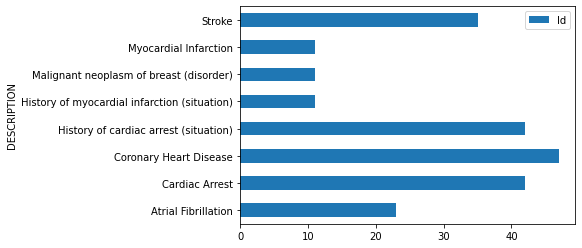

In [90]:
description_count = description.groupby('DESCRIPTION').count()
ax = description_count.plot.barh(stacked=True)

In [88]:
df_NaN = df
df_NaN['DESCRIPTION'] = df_NaN['DESCRIPTION'].fillna('No Information')
description_NaN = df_NaN[['Id','DESCRIPTION']]

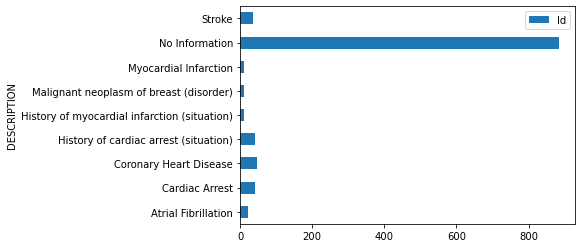

In [89]:
description_NaN_count = description_NaN.groupby('DESCRIPTION').count()
ax = description_NaN_count.plot.barh(stacked=True)

to be continue...